In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import random
import csv
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
hydropath = "C:/Users/Hutto/PycharmProjects/hydromix"
sys.path.append(hydropath)
import hydromix


From https://doi.org/10.1007/s00442-018-4192-5

# Figure 1

In [3]:
#####
#--- theoretical concepts plots ----
#####

#parameter values
nits = 10 #num evap samples
s = 4.5 #EL slope
ssd = 0.5 #slope SD

#prescribed X/Y for sources
swo = [-10.2, -8.5, -5.7, -6.8]
isot = pd.Series(swo, name='swo').to_frame()
isot['swh'] = isot['swo'] * 8 + 10 + np.random.normal(size=4)

def randiso(x):
    enro = np.random.uniform(size=nits)*5
    x['ewo'] = x['swo'] + enro
    x['ewh'] = x['swh'] + enro * (4.5+np.random.normal(size=nits)*ssd)
    return x

isot = isot.apply(lambda x: randiso(x), 1)

#generate samples for correlated model
mths = 12
enoise = 1
seas = (np.sin(2*np.pi*np.arange(0,mths)/mths))
seaso = isot['swo'].mean() + (isot['swo'].max() - isot['swo'].min()/1.5) * seas
seash = seaso * 8 + 10 + np.random.normal(size=mths)
enro = (seas + 1.5) * 2.5 + np.random.normal(size=mths) * enoise
seaseo = seaso + enro
seaseh = seash + enro * (4.5 + np.random.normal(size=mths)*ssd)

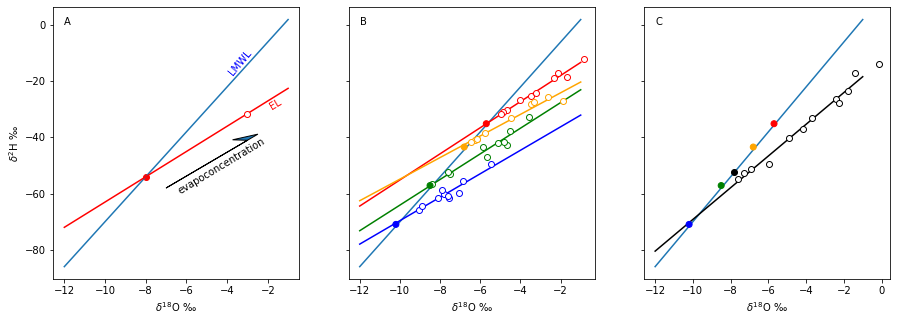

In [4]:
from scipy import stats
fig, ax = plt.subplots(1,3,sharey=True,figsize=(15,5))
x1 = np.arange(-12,0,1)
y1 = [8*i + 10 for i in x1]
y2 = [4.5*i + 10-8*3.5 for i in x1]
ax[0].plot(x1,y1)
ax[0].plot(x1,y2,color='red')
ax[0].scatter(-8,-54, color='red')
ax[0].scatter(-3,-54+5*4.5,edgecolor='red',color='white',zorder=10)
ax[0].set_ylabel(r'$\delta^{2}$' + 'H ' + u'\u2030')
ax[0].text(-4,-18,'LMWL',rotation=50,color='blue')
ax[0].text(-2,-30,'EL',rotation=31,color='red')
ax[0].text(-6.5, -60, "evapoconcentration", rotation=31)
ax[0].text(-12,0,'A')
ax[1].text(-12,0,'B')
ax[2].text(-12,0,'C')
ax[0].arrow(-7,-58,4,17,head_width=1.5,shape='right')
for i in range(len(ax)):
    ax[i].set_xlabel(r'$\delta^{18}$' + 'O ' + u'\u2030')
ax[1].plot(x1,y1)

isot['colors'] = ["blue", "green", "red", "orange"]

for i in isot.index:
    slope, intercept, r_value, p_value, std_err  = stats.linregress(isot.loc[i,'ewo'], isot.loc[i,'ewh'])
    ax[1].scatter(isot.loc[i,'ewo'],isot.loc[i,'ewh'],edgecolor=isot.loc[i,'colors'],color='white',zorder=15)
    ax[1].plot(x1,[slope*j+intercept for j in x1],color=isot.loc[i,'colors'])
ax[1].scatter(isot['swo'], isot['swh'], color=["blue", "green", "red", "orange"],zorder=15)    
ax[2].plot(x1,y1)
ax[2].scatter(seaseo,seaseh,edgecolor='black',color='white',zorder=15)
slope, intercept, r_value, p_value, std_err  = stats.linregress(seaseo,seaseh)
ax[2].plot(x1,[slope*j+intercept for j in x1], color='black')
ax[2].scatter(isot['swo'], isot['swh'], color=isot['colors'],zorder=11)
ax[2].scatter(np.mean(seaso), np.mean(seash), color='black',zorder=11)


Hypothetical examples illustrating iSWE applications. <br>
<p> A. Theoretical framework. Source water values (solid red circle) lie along a
local meteoric water line (LMWL). An evapoconcentrated water sample
(open red circle) has H and O isotope ratios that have evolved relative
to the source along an evaporation line (EL). Measured source
values are back-projected along the EL to its intersection with the
LMWL to estimate the source water values. </p><br>
<p> B. Multiple water samples (open symbols) derived from one of four different ‘source waters’
(solid circles) with random noise and without mixing. In this case, a
regression line fit to each group of evapoconcentrated water samples
approximates the evaporation line slope (true value of 4.5 ± 0.5, estimated
values between 4.24 and 4.74) and projects to an intersection
with the LMWL approximating the actual source water value. </p><br>
<p> C. Multiple evapoconcentrated water samples (open symbols) derived from
varying mixtures of the four sources shown in B. The model shown
includes sinusoidal variation in source water values that is positively
correlated with evapoconcentration, reflecting correlated seasonal
variation in source water isotope ratios and evaporative losses. In this
case, the regression fit over-estimates the EL slope (5.5) and the intercept
between this line and the LMWL gives an estimate of the source
water isotope values that is lower than the true average value (black
solid circle). This figure is available in color in the online version of
the journal</p><br>

# Figure 2

In [5]:
#illustrate case
hsource = hydromix.iso(-46, -7, 1.6, 0.2, 0.8)
obs = hydromix.iso(-27, -3, 0.25, 0.05, 0)

#hypothesized slope value (slope, sd)
hslope = [4.5, 0.3]

#get results and report average conditional probability for test case
results = hydromix.sourceprob(obs, hsource, hslope, ngens=10000)
cond = np.sum(results['Sprob']/len(results))

10000 out of 10000


In [6]:
results.head()

,H_obs,O_obs,obs_prob,H_h,O_h,hypo_prob,slope,Sprob,msk
0,-27.205856,-3.030811,7.502743,-44.739033,-6.873542,0.607638,4.562687,0.978405,1
1,-27.352742,-3.053390,2.660822,-47.634278,-7.109099,0.444076,5.000738,0.248331,1
2,-27.226489,-2.894420,0.908772,-45.844381,-7.131171,0.390652,4.394379,0.939905,1
3,-26.869459,-3.027537,9.546422,-44.890064,-6.793593,0.475051,4.785007,0.636818,1
4,-27.102881,-3.089618,2.347139,-45.832722,-7.065655,0.651331,4.710681,0.781459,1


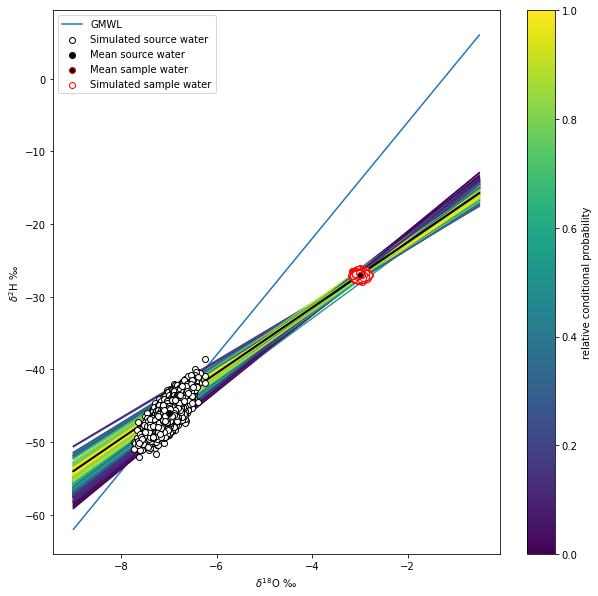

In [52]:
#plt.plot(results['O_h'],results['H_h'])
from matplotlib import cm
fig, ax = plt.subplots(1,1,figsize=(10,10) )
nex = 250
results['S'] = (results['H_obs']-results['H_h'])/(results['O_obs']-results['O_h'])
results['b'] = results['H_obs'] - results['S'] * results['O_obs']
x = np.arange(-9,0,0.5)
y = [8*i + 10 for i in x]
ax.plot(x,y,label="GMWL")
for i in results.index[:250]:
    ax.plot(x,[results.loc[i,'S']*j +results.loc[i,'b'] for j in x], 
            color=cm.viridis(results.loc[i,'Sprob']))
ax.scatter(results['O_h'],results['H_h'],edgecolor='black',color='white',zorder=1000,
           label='Simulated source water')
ax.scatter(hsource.O, hsource.H, color="black",zorder=1001,label='Mean source water')
ax.scatter(obs.O, obs.H, edgecolor="red", color="black",zorder=1001,label='Mean sample water')
ax.scatter(results['O_obs'],results['H_obs'],edgecolor='red',color='white',zorder=1000,
          label='Simulated sample water')
ax.legend()
b = ax.plot(x, [hslope[0]*k + obs['H'] - obs['O'] * hslope[0] for k in x],color='black',linewidth=2,zorder=999)
ax.set_ylabel(r'$\delta^{2}$' + 'H ' + u'\u2030')
ax.set_xlabel(r'$\delta^{18}$' + 'O ' + u'\u2030')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
cbar = plt.colorbar(sm)
cbar.set_label('relative conditional probability')
#fig.colorbar(cm.viridis(results['Sprob']))

# Figure 3

In [56]:
niter  = 50
hsource_o = np.arange(-9, -5, 4/(niter-1))#
#case for precisely known EL slope
hslope = [4.5, 0.1]
ppost=[]
for i in range(niter):
  hsource = hydromix.iso(8*hsource_o[i]+10, hsource_o[i], 1.6, 0.2, 0.8)
  results = hydromix.sourceprob(obs, hsource, hslope)
  ppost.append(sum(results['Sprob'])/len(results))

ppost = [i/np.max(ppost) for i in ppost]

1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
1000 out of 1000
998 out of 1000
996 out of 1000
990 out of 1000
965 out of 1000


In [ ]:
plot(hsource_o, ppost, type="l", axes=FALSE, xlab="", 
     ylab=("Relative conditional probability"), ylim=c(0,1))
axis(1, labels=FALSE)
axis(2)
text(-7.5, 0.4, "this is extra text to help with orientation")
rect(par("usr")[1], par("usr")[3], par("usr")[2], par("usr")[4], col = "grey")
lines(hsource_o, ppost, col="blue")

In [ ]:
#default case
hslope = c(4.5, 0.3)
for(i in 1: niter){
  hsource = iso(8*hsource_o[i]+10, hsource_o[i], 1.6, 0.2, 0.8)
  results = sourceprob(obs, hsource, hslope)
  ppost[i] = sum(results$Sprob)/nrow(results)
}
ppost = ppost/max(ppost)
lines(hsource_o, ppost, col="black")

In [ ]:
#poorly known slope case
hslope = c(4.5, 0.6)
for(i in 1: niter){
  hsource = iso(8*hsource_o[i]+10, hsource_o[i], 1.6, 0.2, 0.8)
  results = sourceprob(obs, hsource, hslope)
  ppost[i] = sum(results$Sprob)/nrow(results)
}
ppost = ppost/max(ppost)
lines(hsource_o, ppost, col="red")

In [ ]:
hsource = iso(-46, -7, 1.6, 0.2, 0.8)
hsource

In [ ]:
hsource = iso(-46, -7, 1.6, 0.2, 0.8)
obs = iso(-27, -3, 0.25, 0.05, 0)

In [ ]:
s = np.random.multivariate_normal([5,10],[[3,2],[2,6]], 1000)

In [ ]:
df = pd.DataFrame(s)
plt.scatter(df[0],df[1])

In [ ]:
hsource = iso(-46, -7, 1.6, 0.2, 0.8)
obs = iso(-27, -3, 0.25, 0.05, 0)

In [ ]:
from scipy.stats import multivariate_normal
from scipy.stats import norm
hsource = iso(-46, -7, 1.6, 0.2, 0.8)
obs = iso(-27, -3, 0.25, 0.05, 0)
hslope = [4.5,0.3]
ngens = 1000

def mskfunc(x):
    if x['H_h'] > x['H_obs'] or x['O_h'] > x['O_obs']:
        return 0
    else:
        return 1
    
def rmvnorm(obs, ngens=10000):
    mean = [obs['H'][0],obs['O'][0]]
    sigma = [[obs['Hsd'][0]**2,obs['HOc'][0]*obs['Hsd'][0]*obs['Osd'][0]],
                         [obs['HOc'][0]*obs['Hsd'][0]*obs['Osd'][0],obs['Osd'][0]**2]]

    s = np.random.multivariate_normal(mean, sigma, ngens)
    return s
    
def sourceprob(obs, hsource, hslope, ngens=1000):
    # ngens observed values
    mean = [obs['H'][0],obs['O'][0]]
    sigma = [[obs['Hsd'][0]**2,obs['HOc'][0]*obs['Hsd'][0]*obs['Osd'][0]],
                         [obs['HOc'][0]*obs['Hsd'][0]*obs['Osd'][0],obs['Osd'][0]**2]]

    s = np.random.multivariate_normal(mean, sigma, ngens)
    HO_obs = pd.DataFrame(s, columns=['H_obs','O_obs'])

    HO_obs['obs_prob'] = HO_obs[['H_obs','O_obs']].apply(lambda x: multivariate_normal.pdf(x, mean=mean, cov=sigma),1)

    # ngens hypothesized source values
    mean = [hsource['H'][0],hsource['O'][0]]
    sigma = [[hsource['Hsd'][0]**2,hsource['HOc'][0]*hsource['Hsd'][0]*hsource['Osd'][0]],
                         [hsource['HOc'][0]*hsource['Hsd'][0]*hsource['Osd'][0],hsource['Osd'][0]**2]]

    s = np.random.multivariate_normal(mean, sigma, ngens)
    HO_h = pd.DataFrame(s, columns=['H_h','O_h'])
    HO_h['hypo_prob'] = HO_h[['H_h','O_h']].apply(lambda x: multivariate_normal.pdf(x, mean=mean, cov=sigma),1)

    HO = pd.concat([HO_obs,HO_h],axis=1)
    HO['slope'] = (HO['H_obs']-HO['H_h'])/(HO['O_obs']-HO['O_h'])

    HO['Sprob'] = norm.pdf(HO['slope'],hslope[0],hslope[1])/norm.pdf(hslope[0],hslope[0],hslope[1])

    HO['msk'] = HO.apply(lambda x: mskfunc(x),1)
    HO['Sprob'] = HO['msk']*HO['Sprob']
    goods = HO['msk'].sum()
    print(f"{goods} out of {ngens}")
    return HO

In [ ]:
np.random.rand(1)

In [ ]:
mwl=[8.01, 9.57, 167217291.1, 2564532.2, -8.096, 80672]
hsource = iso(-46, -7, 1.6, 0.2, 0.8)
obs = iso(-27, -3, 0.25, 0.05, 0)

#hypothesized slope value (slope, sd)
hslope = [4.5, 0.3]

ngens=1000

def mwlsource(obs, hslope, mwl=[8.01, 9.57, 167217291.1, 2564532.2, -8.096, 80672], ngens=10000):

    o_cent = (mwl[1] - (obs['H'][0] - hslope[0]*obs['O'][0]))/(hslope[0]-mwl[0])
    o_min = o_cent - 10
    o_max = o_cent + 5
    sr = np.sqrt((mwl[2]-(mwl[0]**2 * mwl[3]))/(mwl[5]-2))

    mean = [obs['H'][0],obs['O'][0]]
    sigma = [[obs['Hsd'][0]**2,obs['HOc'][0]*obs['Hsd'][0]*obs['Osd'][0]],
                         [obs['HOc'][0]*obs['Hsd'][0]*obs['Osd'][0],obs['Osd'][0]**2]]

    HO_dict = {}
    i = 1
    while i <= ngens:
        HO_obs = np.random.multivariate_normal(mean, sigma, 1)[0]
        O_h = o_min + np.random.rand(1) * (o_max - o_min)

        sy = sr * np.sqrt(1 + 1 / mwl[5] + (O_h - mwl[4])**2 / mwl[3]) 
        H_h = np.random.normal(O_h*mwl[0], sy, 1)
        S = (HO_obs[0]-H_h)/(HO_obs[1]-O_h)
        Sprob = norm.pdf(S, hslope[0], hslope[1])/norm.pdf(hslope[0], hslope[0], hslope[1])

        if H_h > HO_obs[0] or O_h > HO_obs[1]:
            Sprob = 0
        else:
            pass

        if np.random.rand(1) < Sprob:
            hypo_prob = norm.pdf(H_h, O_h*mwl[0]+mwl[1],sy)
            obs_prob = multivariate_normal.pdf([HO_obs[0],HO_obs[1]], mean, cov = sigma)
            HO_dict[i] = [H_h[0], O_h[0], hypo_prob[0], HO_obs[0], HO_obs[1], obs_prob, Sprob[0]]
            i += 1

    HO = pd.DataFrame.from_dict(HO_dict, 
                                orient='index',
                                columns=['H_h', 'O_h', 'hypo_prob', 'H_obs', 'O_obs', 'obs_prob', 'Sprob'])
    return HO

HO =  mwlsource(obs, hslope, mwl=[8.01, 9.57, 167217291.1, 2564532.2, -8.096, 80672], ngens=10000)


In [ ]:
from scipy.stats import dirichlet

In [ ]:
def iso(H, O, Hsd, Osd, HOc):
    varibs = {'H':H, 'O':O, 'Hsd':Hsd, 'Osd':Osd, 'HOc':HOc}
    vardict = {}
    for key in varibs.keys():
        if type(varibs[key]) == np.ndarray or type(varibs[key]) == list:
            pass
        else:
            varibs[key] = np.array(varibs[key])

    if np.size(varibs['H'])==np.size(varibs['O'])==np.size(varibs['Hsd'])==np.size(varibs['HOc']):
        data = []
        if np.size(varibs['H'])>1:
            for i in range(np.size(varibs['H'])):
                print(np.size(varibs['H']))
                data.append([varibs['H'][i],varibs['O'][i],
                             varibs['Hsd'][i],varibs['Osd'][i],
                             varibs['HOc'][i]])
        else:
            data.append([varibs['H'],varibs['O'],
                             varibs['Hsd'],varibs['Osd'],
                             varibs['HOc']])
        return pd.DataFrame(data, columns=['H','O','Hsd','Osd','HOc'])
    else:
        print('lengths of data do not match')
    return pd.DataFrame(data, columns=varibs.keys())

In [ ]:
type(Osd)

In [ ]:
#observed value (H, O, Hsd, Osd, HOcorrelation)
obs = iso(-27, -3, 0.25, 0.05, 0)

#hypothesized source values (data frame; H, O, Hsd, Osd, HOcorrelation)
O = [-9, -3]
H = [i*8 + 10 for i in O]
Hsd = np.repeat(1.6,len(H))
Osd = np.repeat(0.2,len(H))
HOc = np.repeat(0.8,len(H))
hsource = iso(H,O,Hsd,Osd,HOc)
hsource
ho = mixprob(obs, hsource, hslope, prior=None, shp=2, ngens=10000)

In [ ]:
def rmvnorm(obs, ngens=1):
    mean = [obs['H'],obs['O']]
    sigma = [[obs['Hsd']**2,obs['HOc']*obs['Hsd']*obs['Osd']],
                         [obs['HOc']*obs['Hsd']*obs['Osd'],obs['Osd']**2]]

    s = np.random.multivariate_normal(mean, sigma, ngens)[0]
    return s

def dmvnorm(obs, ngens=1):
    x = obs['HO_hypo']
    mean = [obs['H'],obs['O']]
    sigma = [[obs['Hsd']**2,obs['HOc']*obs['Hsd']*obs['Osd']],
                         [obs['HOc']*obs['Hsd']*obs['Osd'],obs['Osd']**2]]
    rv = multivariate_normal(mean, sigma, ngens)
    s = rv.pdf(x)
    return s

In [ ]:
from scipy.stats import dirichlet

shp = 2
prior = None
ngens = 30

def mixprob(obs, hsource, hslope, prior=None, shp=2, ngens=10000):
    nsource = len(hsource)

    mean = [obs['H'][0],obs['O'][0]]
    sigma = [[obs['Hsd'][0]**2,obs['HOc'][0]*obs['Hsd'][0]*obs['Osd'][0]],
                         [obs['HOc'][0]*obs['Hsd'][0]*obs['Osd'][0],obs['Osd'][0]**2]]

    if prior is None:
        prior = np.repeat([1],nsource)
    it = 1    
    i = 1
    HO_hypo = {}
    while i <= ngens:
        HO_obs = np.random.multivariate_normal(mean, sigma, 1)[0]
        hsource['HO_hypo'] = hsource.apply(lambda x: mvnorm(x, 1),1)
        alphas = prior/np.min(prior) * shp
        fracs = dirichlet.rvs(alphas, size = 1)[0]
        H_h = hsource['HO_hypo'].apply(lambda x: x[0]*fracs[0],1).sum()
        O_h = hsource['HO_hypo'].apply(lambda x: x[1]*fracs[0],1).sum()
        if (H_h > HO_obs[0]) or (O_h > HO_obs[1]):
            Sprob = 0
        else:
            S = (HO_obs[0]-H_h)/(HO_obs[1]-O_h)
            Sprob = norm.pdf(S, hslope[0], hslope[1])/norm.pdf(hslope[0], hslope[0], hslope[1])
        if np.random.rand(1) < Sprob:
            obs_prob = multivariate_normal.pdf(HO_obs, mean, cov = sigma)
            fracs_prob = dirichlet.pdf(fracs,alphas)
            hsource['prob_hold'] = hsource.apply(lambda x: mixnorm(x),1)
            hypo_prob = hsource['prob_hold'].product()
            HO_hypo[i] = [H_h, O_h, hypo_prob, 
                          HO_obs[0], HO_obs[1],
                          obs_prob, fracs, fracs_prob, Sprob]
            i+=1

        it += 1
        if it > 10000 and i/it < 0.01:
            print("too few valid draws")
            break
    HO = pd.DataFrame.from_dict(HO_hypo, 
                                    orient='index',
                                    columns=['H_h', 'O_h', 'hypo_prob', 
                                             'H_obs', 'O_obs', 
                                             'obs_prob', 'fracs', 'fracs_prob', 'Sprob'])
    print(f"{it} iterations for {ngens} posterior samples")
    return HO


In [ ]:
fracs

In [ ]:
HO_obs[0]

In [ ]:
HO_obs = np.random.multivariate_normal(mean, sigma, 1)
HO_obs

In [ ]:
hsource = iso(-46, -7, 1.6, 0.2, 0.8)
obs = iso(-27, -3, 0.25, 0.05, 0)

#hypothesized slope value (slope, sd)
hslope = [4.5, 0.3]

df = sourceprob(obs, hsource, hslope, ngens=10000)
plt.scatter(x=df.index, y=df['Sprob'])

In [ ]:
HO['S']

In [ ]:
#illustrate case
hsource = iso(-46, -7, 1.6, 0.2, 0.8)
obs = iso(-27, -3, 0.25, 0.05, 0)

#hypothesized slope value (slope, sd)
hslope = c(4.5, 0.3)

In [ ]:
from scipy.stats import multivariate_normal
var = multivariate_normal(mean=[0,0], cov=[[1,0],[0,1]])
var.pdf([1,0])

In [ ]:
s = np.random.multivariate_normal([obs['H'][0],obs['O'][0]], sigma, 1000)
df = pd.DataFrame(s)
df.plot(x=0,y=1,kind='scatter')

In [ ]:
x = np.array(["A", "B"])
print np.repeat(x, [2, 3], axis=0)